### Imports and Installs

In [2]:
!pip install statsmodels
!pip install pystan~=2.14
!pip install fbprophet
!pip install jupyter-dash
!pip install ruptures

     |████████████████████████████████| 9.6 MB 41.0 MB/s 
     |████████████████████████████████| 357 kB 49.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=2fba1cc741a3679d6db9ccf806343f1c012f9847545acfab3775e107d2be4f90
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
     |████████████████████████████████| 991 kB 26.4 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import ruptures as rpt
from sklearn.metrics import r2_score

## dash imports
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from datetime import datetime
mydateparser = lambda x: datetime.strptime(x, "%Y-%m-%d")
station_data = pd.read_parquet('2020-2022_history_data_processed.parquet.brotli', parse_dates=['Date'], date_parser = mydateparser )
station_data.head()

,Station,City,State,Date,Time,PM25,PM10,CO,NO2,NH3,O3,SO2,AQI,AQI_bucket
0,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,10:00:00,32.76,37.19,0.57,6.28,11.40,130.18,12.88,176.0,Moderate
1,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,11:00:00,43.00,50.81,0.82,13.66,19.00,97.28,15.50,176.0,Moderate
2,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,12:00:00,51.04,61.88,1.04,22.77,25.08,63.66,17.17,176.0,Moderate
3,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,13:00:00,55.24,68.78,1.12,26.22,29.64,42.20,16.69,176.0,Moderate
4,"Adarsh Nagar, Jaipur, India",Jaipur,Rajasthan,2020-11-28,14:00:00,58.45,73.32,1.12,24.04,29.89,33.98,15.26,176.0,Moderate


In [6]:
city_data = station_data.groupby(['City','Date']).mean().reset_index()
city_data.head()

,City,Date,PM25,PM10,CO,NO2,NH3,O3,SO2,AQI
0,Agartala,2020-11-28,104.606429,124.784286,1.040000,14.719286,10.559286,43.337143,1.912857,245.642857
1,Agartala,2020-11-29,97.869167,115.230833,0.973750,11.354583,16.983750,62.903750,2.817083,252.041667
2,Agartala,2020-11-30,126.995417,147.259583,1.184583,17.886250,14.861667,60.678750,4.024167,274.833333
3,Agartala,2020-12-01,120.864167,140.599167,0.992917,11.260417,10.057083,67.114167,4.995000,294.750000
4,Agartala,2020-12-02,139.565833,164.991667,1.170417,12.983750,13.930417,58.895417,5.323750,312.708333


### ARIMA

In [7]:
delhi = city_data.loc[city_data['City']=='Delhi'][['Date','AQI']]
delhi.reset_index(level=0,inplace=True,drop=True)
delhi.head()

,Date,AQI
0,2020-11-28,370.785714
1,2020-11-29,432.583333
2,2020-11-30,621.000000
3,2020-12-01,699.875000
4,2020-12-02,653.833333


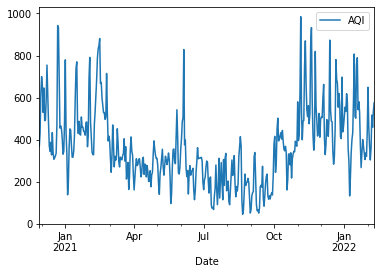

In [8]:
import matplotlib.pyplot as plt

first = delhi.copy()
first.plot.line(x='Date', y='AQI')

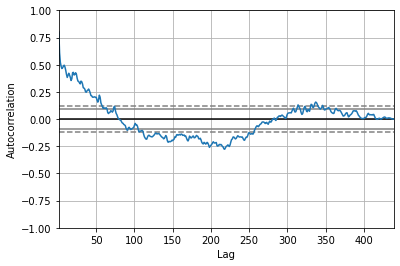

In [9]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(first['AQI'])

In [10]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
# fit model
p,d,q = 3,1,0
model = ARIMA(first['AQI'], order=(p,d,q))
model_fit = model.fit()

In [12]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.AQI   No. Observations:                  438
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2671.470
Method:                       css-mle   S.D. of innovations            107.777
Date:                Tue, 12 Apr 2022   AIC                           5352.941
Time:                        04:50:19   BIC                           5373.352
Sample:                             1   HQIC                          5360.994
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2166      3.480      0.062      0.950      -6.605       7.038
ar.L1.D.AQI    -0.0607      0.047     -1.285      0.199      -0.153       0.032
ar.L2.D.AQI    -0.2701      0.046     -5.922    

In [13]:
data = delhi['AQI'].values

In [14]:
len(data)*0.8

351.20000000000005

In [15]:
train_size = int(len(data) * 0.80)
train, test = data[0:train_size], data[train_size:len(data)]

In [16]:
history = [x for x in train]
predictions = list()

In [17]:
for t in range(len(test)):
  model = ARIMA(history, order=(3,1,0))
  model_fit = model.fit()
  pred = model_fit.predict(len(test))
  yhat = pred[0]
  predictions.append(yhat)
  # Append test observation into overall record
  obs = test[t]
  history.append(obs)

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 508.957


### Fb Prophet

In [19]:
df = city_data.rename(columns={'Date': 'ds', 'AQI':'y'})
df.head()

,City,ds,PM25,PM10,CO,NO2,NH3,O3,SO2,y
0,Agartala,2020-11-28,104.606429,124.784286,1.040000,14.719286,10.559286,43.337143,1.912857,245.642857
1,Agartala,2020-11-29,97.869167,115.230833,0.973750,11.354583,16.983750,62.903750,2.817083,252.041667
2,Agartala,2020-11-30,126.995417,147.259583,1.184583,17.886250,14.861667,60.678750,4.024167,274.833333
3,Agartala,2020-12-01,120.864167,140.599167,0.992917,11.260417,10.057083,67.114167,4.995000,294.750000
4,Agartala,2020-12-02,139.565833,164.991667,1.170417,12.983750,13.930417,58.895417,5.323750,312.708333


In [20]:
grouped = df.groupby('City')
final = pd.DataFrame()

for g in grouped.groups:
  threshold_min = 0.975
  group = grouped.get_group(g)

  ## Getting holidays
  df_abnorm = group[(group['y'] >= np.quantile(group['y'], threshold_min))]
  anomalous_dates = df_abnorm['ds'].astype('str').tolist()
  anomalous = pd.DataFrame({
  'holiday': 'anomalous',
  'ds': pd.to_datetime(anomalous_dates),
  'lower_window': -4,
  'upper_window': 4,
  'prior_scale': 20 })

  # Build Prophet model with parameters and structure 
  model = Prophet(changepoint_range=1, changepoint_prior_scale = 0.5,
                holidays=anomalous, seasonality_mode = 'multiplicative')
  model.add_seasonality(name='weeks', period=365.25/52, fourier_order=3, 
                        mode = 'multiplicative', prior_scale = 0.5)
  model.add_seasonality(name='month', period=365.25/12, fourier_order=5, 
                        mode = 'multiplicative', prior_scale = 0.3)
  model.add_seasonality(name='year', period=365.25, fourier_order=10, 
                      mode = 'multiplicative', prior_scale = 0.15)

  # Training model for df
  model.fit(group)
  future_dates = model.make_future_dataframe(periods=30)
  prediction = model.predict(future_dates) 
  prediction = prediction.rename(columns={'yhat': 'yhat_'+g})
  prediction = prediction[['ds', 'yhat_'+g]]
  final = pd.merge(final, prediction.set_index('ds'), how='outer', left_index=True, right_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [21]:
final.head()

,yhat_Agartala,yhat_Agra,yhat_Ahmedabad,yhat_Aizawl,yhat_Ajmer,yhat_Alwar,yhat_Amaravati,yhat_Ambala,yhat_Amritsar,yhat_Ankleshwar,...,yhat_Thrissur,yhat_Tirupati,yhat_Udaipur,yhat_Ujjain,yhat_Vapi,yhat_Varanasi,yhat_Vijayapura,yhat_Visakhapatnam,yhat_Vrindavan,yhat_Yadgir
ds,,,,,,,,,,,,,,,,,,,,,
2020-11-28,286.152341,316.055010,227.490296,76.476819,154.139439,220.154156,224.217288,374.311364,396.434034,146.168707,...,91.419775,96.960359,119.703300,144.053449,143.240993,415.401120,120.871277,265.729727,277.191827,109.252585
2020-11-29,273.321758,313.274003,205.284187,77.805997,151.170794,212.713994,215.227223,358.962618,372.315749,132.703282,...,90.560198,97.500920,112.952967,130.002075,126.122008,378.022633,105.753082,230.386705,268.155272,96.762323
2020-11-30,287.060566,312.581007,227.297873,90.388392,139.799817,202.897493,238.333141,347.335719,372.496316,146.022950,...,87.816376,99.003109,112.856330,130.655862,147.356733,387.881534,104.116089,262.201504,269.962281,98.237803
2020-12-01,303.264940,327.200502,280.465034,99.909113,133.449986,192.321401,285.753591,368.514665,404.056412,146.786109,...,88.188747,118.138025,109.371058,140.785290,195.430665,420.216261,111.828947,285.127481,287.704790,107.701096
2020-12-02,306.065983,350.568215,304.940406,91.660305,128.999642,211.443684,298.751465,377.162388,412.054333,168.460955,...,89.640870,125.361248,111.270715,148.715584,222.989432,454.908618,118.607635,294.265628,311.604785,124.243285


### Dash UI

In [22]:
cities = city_data.City.unique()

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id="dropdown",
        options=[{"label": x, "value": x} 
                 for x in cities],
        value="Delhi",
        placeholder="Select a city"
    ),
    dcc.Graph(id="line-chart")
])

@app.callback(
    Output("line-chart", "figure"), 
    Input("dropdown", "value"))
def update_line_chart(city):

    city_df = city_data.loc[city_data['City']==city]

    fig = px.line(data_frame=city_df,
        x='Date', y='AQI', color='City', title = "AQI line chart from 2021-2022")  # 'plotly_dark'

    fig.add_trace(go.Scatter( x=final.index, y=final['yhat_'+city].to_numpy(), name="pred", line_shape='linear'))
    return fig

app.run_server(mode='inline')

<IPython.core.display.Javascript object>